Question 1

In [1]:
from bs4 import BeautifulSoup
import requests
from operator import itemgetter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgmpy as pg
import tabulate as tb
import networkx as nx
import sklearn
import networkx as nx
from pgmpy.models import BayesianNetwork, BayesianModel
from pgmpy.estimators import TreeSearch
from pgmpy.estimators import BayesianEstimator, ExpectationMaximization, MaximumLikelihoodEstimator
from IPython.core.display import display, HTML
from pgmpy.metrics.metrics import correlation_score, log_likelihood_score, structure_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
#Here is a series of functions that makes future code more readable

#This function creates a BeautifulSoup instance using the link of the publication page
def createPageSoup(pub_page_link):
    pub_page = requests.get(pub_page_link)
    pub_page_soup = BeautifulSoup(pub_page.content, "html.parser")
    return(pub_page_soup)

#this function obtains the page title from the link.
def getTitle(pub_page_link):
    soup = createPageSoup(pub_page_link)
    
    #scrape for the title
    title_div = soup.find("h1", attrs = {"style":"text-align: center"})
    if title_div != None:
        title_of_pub = title_div.text
    else:
        print("No title div found.") 
    
    return(title_of_pub)

def fetchAuthors(pub_page_link):
    authors = []
    soup = createPageSoup(pub_page_link)
    author_div = soup.find("h2", attrs = {"style":"text-align: center"})
    if author_div != None:
        links = author_div.find_all("a")
        if links != None:
            for link in links:
                authors.append(link.contents[0])
    return(authors)

def fetchCitationNumber(pub_page_link):
    soup = createPageSoup(pub_page_link)
    pub_details_div = soup.find("div", attrs = {"style":
                                                "margin-left: var(--size-marginleft);text-align: center"})
    if pub_details_div != None:
        citation_div = pub_details_div.find("div", attrs = {"style" : "color:orange"})
        if citation_div != None:
            citation_text = (citation_div.text)
            text_citation_index = citation_text.find("Citation")
            
            #Check if article has any citations, if not, give it a value of 0
            if text_citation_index != -1:
                #ten from when "Citation" starts gives us the number starting index
                number_citation_start_index = text_citation_index + 10
                #using the .text property, the number stops right before the "#" symbol
                number_citation_stop_index = citation_text.find("#", number_citation_start_index)
                
                citation_number = citation_text[number_citation_start_index: number_citation_stop_index]
                return(citation_number)
            else:
                return(0)
                print(f"No citations found for \"{title_of_pub}\"!")
        else:
            print("No citation div found.")
    else:
        print("No publication details div found.")
    
def fetchImpactFactor(pub_page_link):
    soup = createPageSoup(pub_page_link)
    pub_details_div = soup.find("div", attrs = {"style":
                                                "margin-left: var(--size-marginleft);text-align: center"})
    if pub_details_div != None:
        IF_div = pub_details_div.find("div", attrs = {"style" : "color:orange"})
        if IF_div != None:
            IF_text = (IF_div.text)
            IF_text_index = IF_text.find("Impact Factor:")
            
            #Check if article has an Impact Factor, if not, give it a value of None
            if IF_text_index != -1:
                #ten from when "Impact Factor" starts gives us the number starting index
                IF_start_index = IF_text_index + 16
                #using the .text property, the number stops right before the "#" symbol
                IF_stop_index = IF_text.find("#", IF_start_index)
                
                impact_factor = IF_text[IF_start_index: IF_stop_index]
                return(impact_factor)
            else:
                return None
                print(f"No impact factor found for \"{title_of_pub}\"!")
        else:
            print("No IF_div found.")
    else:
        print("No publication details div found.")


Question 1

In [3]:
url = "https://sitescrape.awh.durham.ac.uk/comp42315/index.htm"

#First, load the home page and find the "publications" link:

page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
body = soup.find("body", class_ = "PageDefault")
if body != None:
    navigator_div = body.find("div", class_ = "navigator")
    if navigator_div != None:
        navigator_tags = navigator_div.find_all("span")
        if navigator_tags != None:
            #We set up a flag to tell us if we have found the publications button.
            button_found = False
            for tag in navigator_tags:
                #since each instance of tag.contents is stored in its own array we index for each tag in the loop
                if tag.contents[0].upper() == "PUBLICATIONS":
                    #obtain the <a> tag using the .parent property twice
                    link_tag = (tag.contents[0].parent).parent
                    link = link_tag['href']
                    button_found = True
                    
            if button_found == False:
                print("No publications button found.")
        else:
            print("No reference to 'Publications' in the navigator tags.")
    else: 
        print("No navigator div found")
else:
    print("No body div found.")

#now we modify the original url to get to the publications page.
base_url = url[:-9]
#and then concatenate the base url and summand link to get the complete link to the publications page:
publications_page_link = base_url + link

#Access the publications page and obtain links for all the topics
page_soup = createPageSoup(publications_page_link)
textOption_tags = page_soup.find_all("p", class_ = "TextOption")

#Again we set up a flag to tell us if we have found a topics list 
#after looping through the same-class "TextOption" tags.
if textOption_tags != None:
    topics_list_found = False

    for tag in textOption_tags:
        #Find which div tag has "Topic" in its contents - this refers to the tag
        #that contains all the topics that we can crawl through.
        if (tag.contents[0]).startswith("Topic"):
            topics_list_found = True

            topics_list_tags = tag.find_all("a")
            #Note that it doesn't include the link of the page it is already on.
            #To fix this we add the link of the publication page found after the loop.
            topics_list_links = []
            topics_list_links.append(publications_page_link)

            for topic_tag in topics_list_tags:
                topics_list_links.append(base_url + topic_tag['href'])
            
    if not topics_list_found:
        print("No topic tabs found")
    
#Now, for each topic page we scrape all the links to the publications from the images to get all the pages
#start by accessing the page
pub_links = []

#For future reference we keep the topics that each link is obtained from in a dictionary.
#Dictionary is of the form like {publication link : list of topic links}
pub_link_and_topics = dict()

for topic_page_link in topics_list_links:
    
    
    topic_page = requests.get(topic_page_link)
    topic_page_soup = BeautifulSoup(topic_page.content, "html.parser")
    pub_divs = topic_page_soup.find_all("div", attrs = {"style" : "margin-left: var(--size-marginleft)"})
    if pub_divs != None:
        for pub_div in pub_divs:
            imgicon_divs = pub_div.find_all("div", class_ = "ImgIconPublicationDiv")
            if imgicon_divs != None:
                for imgicon_div in imgicon_divs:
                    pub_link_tag = imgicon_div.find("a")
                    pub_link = pub_link_tag['href']
                    complete_pub_link = base_url + pub_link
                    
                    #Adds publication link to list of publications
                    pub_links.append(complete_pub_link)
                    
                    #add topic to existing list of topics, or if it does not exist,
                    #to a new list 
                    if complete_pub_link not in pub_link_and_topics:
                        pub_link_and_topics[complete_pub_link] = []
                        pub_link_and_topics[complete_pub_link].append(topic_page_link)                        
                    else:
                        pub_link_and_topics[complete_pub_link].append(topic_page_link)
            else: 
                print("No image icon divs found.")
    else:
        print("No publication divs found.")

#We remove duplicates using the set() function and setting it equal to pub_links again.
pub_links = list(set(pub_links))

#Now, we iterate through the list of publications to scrape for the title and number of citations

pub_and_citations = dict()

for pub_page_link in pub_links:
    pub_page = requests.get(pub_page_link)
    pub_page_soup = BeautifulSoup(pub_page.content, "html.parser")
    
    #scrape for the tilte
    title_of_pub = getTitle(pub_page_link)
    
    #now for the citations
    citation_number = fetchCitationNumber(pub_page_link)
    pub_and_citations[title_of_pub] = int(citation_number)


#now create the table of the top 25 citations
sorted_pub_citations_tuples = sorted(pub_and_citations.items(), key = itemgetter(1), reverse = True)
sorted_pub_citations_lists = []

#sorted list as required
for publication in sorted_pub_citations_tuples:
    sorted_pub_citations_lists.append([publication[0], publication[1]])

In [4]:
#list of the top 25 only
top_25_citations_list = sorted_pub_citations_lists[0:25]

np_array_of_top_25_citations = np.array(top_25_citations_list)
top_25_citations_table = pd.DataFrame(columns = ["Title of publication", "Number of Citations"], index = range(1,26))
top_25_citations_table.index.name = "Position"
top_25_citations_table["Title of publication"] = np_array_of_top_25_citations[:,0]
top_25_citations_table["Number of Citations"] = np_array_of_top_25_citations[:,1]

In [5]:
display(HTML(top_25_citations_table.to_html()))

,Title of publication,Number of Citations
Position,,
1,A Quadruple Diffusion Convolutional Recurrent Network for Human Motion Prediction,228
2,Interaction Patches for Multi-Character Animation,201
3,Real-Time Posture Reconstruction for Microsoft Kinect,150
4,Simulating Multiple Character Interactions with Collaborative and Adversarial Goals,112
5,Simulating Competitive Interactions using Singly Captured Motions,112
6,Simulating Interactions of Avatars in High Dimensional State Space,102
7,Kinect Posture Reconstruction based on a Local Mixture of Gaussian Process Models,98
8,Interaction-based Human Activity Comparison,88
9,Environment-aware Real-Time Crowd Control,79


Question 2

In [6]:
# For simplicity we define a class for each publication, to hold several properties: 
# title, year of publication, its link, and the number of LDO items, citation number, impact factor, 
# the authors, and topics
class Publication:
    def __init__(self, link, title, year, number_LDOs, citation_number, topics, authors, impact_factor):
        self.link = link
        self.title = title
        self.year = year
        self.number_LDOs = number_LDOs
        self.citation_number = citation_number
        self.topics = topics
        self.authors = authors
        self.impact_factor = impact_factor


# Now we create Publication class instances by scraping for the year on each page, as well as the title
# and the LDOs. While scraping this information we also 
# We reuse some of the code from Q1.
pub_page_objects = []

for pub_page_link in pub_links:
    pub_page_soup = createPageSoup(pub_page_link)
    
    title_of_pub = getTitle(pub_page_link)
    
    #scrape for the year
    year_block = pub_page_soup.find("h2", attrs = {"style":"text-align: center"})
    if year_block != None:
        # Note that the year is always the last item in the h2 block, the .contents
        # property of which stores items in a list.
        year = int(year_block.contents.pop())
    else:
        print("No h2 block found")
    
    # scrape for the number of LDOs.
    # the block for the LDO items has a similar style to the block
    # for publication details. Therefore we first search for the string
    # "Links, Downloads and Online Resources" and then search for all the
    # divs in the following div at the same level using the find_next_siblings() function
    
    h2_tags = pub_page_soup.find_all("h2")
    for h2_tag in h2_tags:
        if str(h2_tag.contents[0]).startswith("Links"):
            post_links_header = h2_tag.find_next()
            #this gives us the div containing all the LDOs and so we search for the first
            #LDO object before finding the others on the same hierarchical level.
            if post_links_header != None:
                link_div = post_links_header.find("div")
                if link_div != None:
                    ldo_divs = link_div.find_next_siblings("div")
                    #add the first ldo back into the list
                    ldo_divs.append(link_div)
                    number_of_LDOs = len(ldo_divs)
                else:
                    print("No link_div found!")
            else:
                print("No post_links_header found!")
                    
    #Now we set citation number as previously obtained in Q1
    citation_number = pub_and_citations[getTitle(pub_page_link)]
    
    #Here we set the topics by looking at the links and topics links dictionary created previously,
    #then obtaining the topic names from the topic page URLs, and adding them to a list:
    topic_URLs = pub_link_and_topics[pub_page_link]
    topics = []
    for topic_URL in topic_URLs:
        #to extract the name of the topic we scrape the topics bar for the text property, since the only text that
        #is not a link is the selected topic
        topic_page = requests.get(topic_URL)
        topic_page_soup = BeautifulSoup(topic_page.content, "html.parser")
        title_div = topic_page_soup.find("title")
        endOfTopicTitle = title_div.text.find(" Research Publications")
        topic_name = title_div.text[0:endOfTopicTitle]
        topics.append(topic_name)
        
    #Now we get the list of authors
    authors = fetchAuthors(pub_page_link)
    
    #Get the impact factor
    impact_factor = fetchImpactFactor(pub_page_link)
    
    
    pub_page_object = Publication(link = pub_page_link, title = title_of_pub, 
                                  year = year, number_LDOs = number_of_LDOs,
                                  citation_number = citation_number, topics = topics, 
                                  authors = authors, impact_factor = impact_factor)
    
    pub_page_objects.append(pub_page_object)


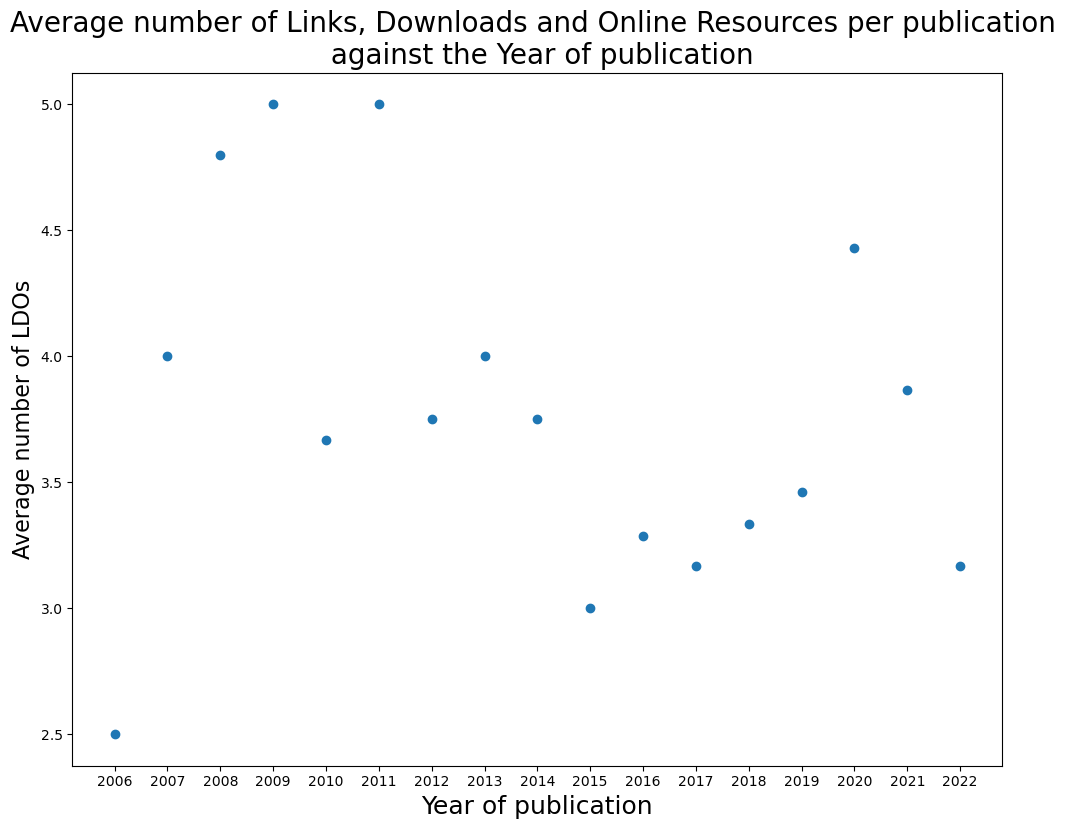

In [7]:
#Now, we can start by calculating the number of LDOs over all publications in a year, 
#and the number of publications per year. First we calculate the number of LDOs over
#all publications in every year, storing the result in a dictionary.

year_number_LDOs = dict()
for pub_page in pub_page_objects:
    year_number_LDOs[str(pub_page.year)] = year_number_LDOs.get(str(pub_page.year), 0) + pub_page.number_LDOs

#We do the same for number of publications per year
year_number_pubs = dict()
for pub_page in pub_page_objects:
    year_number_pubs[str(pub_page.year)] = year_number_pubs.get(str(pub_page.year), 0) + 1

# Now we can calculate the average number of LDO items against the year of publication 
# by dividing the values in year_number_LDOs by the values in year_number_pubs
year_average_LDOs = dict()
for year in year_number_LDOs:
    average_LDOs = year_number_LDOs[year] / year_number_pubs[year]
    year_average_LDOs[year] = average_LDOs

#we sort the results via the sorted() function and list comprehensions, before plotting the scatter plot.
sorted_avg_LDOs_by_year_tuples = sorted(year_average_LDOs.items(), key = itemgetter(0))
sorted_years_in_list = [item[0] for item in sorted_avg_LDOs_by_year_tuples]
sorted_LDOs_in_list = [item[1] for item in sorted_avg_LDOs_by_year_tuples]


plt.figure(figsize=(12,9))
plt.scatter(sorted_years_in_list, sorted_LDOs_in_list)
plt.title("Average number of Links, Downloads and Online Resources per publication \n against the Year of publication", fontsize = 20)
plt.xlabel('Year of publication', fontsize=18)
plt.ylabel('Average number of LDOs', fontsize=16)
plt.show()

In [8]:
# Now to find the name and number of LDO items of the top 25 publications according to the LDO items.
# To do this, create a list that is sorted by the number of LDO objects using the 
# the sorted() method and a lambda ("anonymous") function that gets the number_LDOs 
# class property from the class instance (we use the lambda function because we can define and call)
# it on the same line.
    
sorted_pubs_and_LDOs = sorted(pub_page_objects, key = lambda publication: publication.number_LDOs, 
                              reverse = True)
top_25_pubs_by_LDOs = sorted_pubs_and_LDOs[0:25]

#we use a list comprehension to give the position, title and number of LDOs for each
#publication in the top 25.
name_and_number_LDOs_of_top_25 = [(top_25_pubs_by_LDOs.index(pub) + 1,pub.title, pub.number_LDOs) 
                                  for pub in top_25_pubs_by_LDOs]

print(*name_and_number_LDOs_of_top_25, sep = "\n")


(1, 'Interaction Patches for Multi-Character Animation', 8)
(2, 'Foreground-aware Dense Depth Estimation for 360 Images', 6)
(3, 'Resolving Hand-Object Occlusion for Mixed Reality with Joint Deep Learning and Model Optimization', 6)
(4, 'Simulating Multiple Character Interactions with Collaborative and Adversarial Goals', 6)
(5, 'Makeup Style Transfer on Low-quality Images with Weighted Multi-scale Attention', 6)
(6, 'Simulating Interactions of Avatars in High Dimensional State Space', 6)
(7, 'DSPP: Deep Shape and Pose Priors of Humans', 6)
(8, 'Formation Control for UAVs Using a Flux Guided Approach', 5)
(9, 'Angular Momentum Guided Motion Concatenation', 5)
(10, 'Interaction-based Human Activity Comparison', 5)
(11, 'A Quadruple Diffusion Convolutional Recurrent Network for Human Motion Prediction', 5)
(12, 'A Unified Deep Metric Representation for Mesh Saliency Detection and Non-rigid Shape Matching', 5)
(13, 'Data-Driven Crowd Motion Control with Multi-touch Gestures', 5)
(14, 'Rea

In [9]:
#Formatting data for display in a table.
name_and_number_LDOs_of_top_25_list = [[pub.title, pub.number_LDOs] for pub in top_25_pubs_by_LDOs]
np_array_top_25_pubs_LDO = np.array(name_and_number_LDOs_of_top_25_list)

top_25_pubs_by_LDO_table = pd.DataFrame(columns = ["Title of publication", "Number of LDOs"], index = range(1,26))
top_25_pubs_by_LDO_table.index.name = "Position"
top_25_pubs_by_LDO_table["Title of publication"] = np_array_top_25_pubs_LDO[:,0]
top_25_pubs_by_LDO_table["Number of LDOs"] = np_array_top_25_pubs_LDO[:,1]

In [10]:
display(HTML(top_25_pubs_by_LDO_table.to_html()))

,Title of publication,Number of LDOs
Position,,
1,Interaction Patches for Multi-Character Animation,8
2,Foreground-aware Dense Depth Estimation for 360 Images,6
3,Resolving Hand-Object Occlusion for Mixed Reality with Joint Deep Learning and Model Optimization,6
4,Simulating Multiple Character Interactions with Collaborative and Adversarial Goals,6
5,Makeup Style Transfer on Low-quality Images with Weighted Multi-scale Attention,6
6,Simulating Interactions of Avatars in High Dimensional State Space,6
7,DSPP: Deep Shape and Pose Priors of Humans,6
8,Formation Control for UAVs Using a Flux Guided Approach,5
9,Angular Momentum Guided Motion Concatenation,5


Question 3a

In [11]:
#Start by defining a new Author class that will allow you to store the number
#of times they were cited, the authors they worked with (and no of times), and their publications
class Author:
    def __init__(self, name, publications, times_cited, coauthors,):
        self.name = name
        self.publications = publications
        self.times_cited = times_cited
        self.coauthors = coauthors



In [12]:
#We compute the number of times each author has been cited.

# Can do this by finding the citation count of each article.
# At the same time we initialise an Author object and add all the
# necessary details.

author_objects = []
for pub_page in pub_page_objects:
    for author in pub_page.authors:
        
        authors = pub_page.authors
        
        #if we have the author object already in the all authors list, update their details by 
        #adding publications, times_cited, and their coauthors+collaboration count
        
        #Initialise a new author object, but if the object already exists
        #then edit the details instead
        author_object_names = [obj.name for obj in author_objects]
        
        if author not in author_object_names:
            coauthors_collaborated = dict()
            for coauthor in authors:
                if coauthor != author:
                    coauthors_collaborated[coauthor] = 1

            author_object = Author(name = author, publications = [pub_page], 
                                           times_cited = pub_page.citation_number,  
                                           coauthors = coauthors_collaborated)

            author_objects.append(author_object)
        
        #already exists
        else:
            for obj in author_objects:
                if author == obj.name:
                    (obj.publications).append(pub_page)
                    obj.times_cited += pub_page.citation_number
                    #get each coauthor by checking it is not the same as the author
                    for coauthor in authors:
                        if coauthor != author:
                            obj.coauthors[coauthor] = (obj.coauthors).get(coauthor,0) + 1

In [13]:
#Now we can sort the author objects for the top 10 highly cited authors:
authors_by_citations = sorted(author_objects, key = lambda author: author.times_cited, reverse = True)
top_10_authors_by_citations = authors_by_citations[0:10]
top_10_authors_names_citations = [[author.name, author.times_cited] for author in top_10_authors_by_citations]
np_top_10_authors_names_citations = np.array(top_10_authors_names_citations)

top_10_authors_names_citations_table = pd.DataFrame(columns = ["Name", "Times Cited"], index = range(1,11))
top_10_authors_names_citations_table.index.name = "Position"
top_10_authors_names_citations_table["Name"] = np_top_10_authors_names_citations[:,0]
top_10_authors_names_citations_table["Times Cited"] = np_top_10_authors_names_citations[:,1]
display(HTML(top_10_authors_names_citations_table.to_html()))

,Name,Times Cited
Position,,
1,Hubert P. H. Shum,3266
2,Edmond S. L. Ho,1140
3,Taku Komura,1052
4,Howard Leung,655
5,Shuntaro Yamazaki,527
6,Qianhui Men,369
7,Shigeo Morishima,261
8,Nauman Aslam,260
9,Longzhi Yang,236


In [14]:



#Check which topics in which these authors work, and how often:
for author in top_10_authors_by_citations:
    #dict to show how often they work in that topic
    author_topics_freq = dict()
    
    #dict to show who their coauthors are per topic, and how often those coauthors appear
    topic_coauthors = dict()
    
    # Find the publications of the top 10 authors, see how often they write
    # in that topic, and then look at the coauthors based on the research topic
    for publication in author.publications:
        
        for topic in publication.topics:
            #how often do they write in that topic?
            author_topics_freq[topic] = author_topics_freq.get(topic,0) + 1
            
            for coauthor in publication.authors:
                if coauthor != author.name:
                    if topic_coauthors.get(topic) != None:
                        
                        nested_keys = []
                        outer_values = topic_coauthors[topic]
                        for inner_dict in outer_values:
                            nested_keys.append(inner_dict)
                        
                        if coauthor not in (nested_keys):
                            (topic_coauthors[topic])[coauthor] = 1

                        else:
                            (topic_coauthors[topic])[coauthor] += 1

                    else: 
                        topic_coauthors[topic] = dict()
                        (topic_coauthors[topic])[coauthor] = 1
   
                        
                         

    #how often they work in that topic                
    topic_freq_list = (sorted(author_topics_freq.items(), key = itemgetter(1), reverse = True))
    
    print(author.name, topic_freq_list, topic_coauthors, sep = "\n\n")
            

        

Hubert P. H. Shum

[('Character Animation', 26), ('Interaction Modelling', 20), ('Motion Analysis', 20), ('Biomedical Engineering', 17), ('3D Reconstruction', 16), ('Action Recognition', 15), ('Surface Modelling', 11), ('Virtual Reality', 9), ('Face Modelling', 9), ('Crowd Modelling', 9), ('Biometrics', 8), ('Robotics', 8), ('Hand and Gesture', 7), ('Computational Intelligence', 7)]

{'Virtual Reality': {'Christopher Flinton': 1, 'Philip Anderson': 1, 'Edmond S. L. Ho': 2, 'Zhiying Leng': 1, 'Jiaying Chen': 2, 'Frederick W. B. Li': 2, 'Xiaohui Liang': 2, 'Qi Feng': 3, 'Shigeo Morishima': 3, 'Kevin D. McCay': 1, 'Longzhi Yang': 1, 'Kanglei Zhou': 1, 'Yang Yang': 1, 'Howard Leung': 1, 'Nauman Aslam': 1, 'Zhigeng Pan': 1, 'Taku Komura': 1, 'Shu Takagi': 1}, 'Character Animation': {'He Wang': 3, 'Edmond S. L. Ho': 10, 'Zhanxing Zhu': 1, 'Taku Komura': 11, 'Haozheng Zhang': 1, 'Ziyi Chang': 1, 'Pranjul Yadav': 1, 'Qianhui Men': 2, 'Howard Leung': 3, 'Liuyang Zhou': 1, 'Lifeng Shang': 1, 'Ja

In [15]:
#In which topics do authors collaborate the most? 
#Loop through all the publications and check which topics has the highest average number of authors

top_10_author_publications = []
for author in top_10_authors_by_citations:
    
    # Add the publications of the top 10 authors to a list
    for publication in author.publications:
        if publication not in top_10_author_publications:
            top_10_author_publications.append(publication)

#Now for each topic we try to see where there is the highest total number of authors per number of pubs in that topic.
pubs_by_topic = dict()
total_authors_by_topic = dict()
#While performing this loop we also collect data on how many citations there are per topic for future use.
citations_by_topic = dict()

for pub in top_10_author_publications:
    for topic in pub.topics:
        pubs_by_topic[topic] = pubs_by_topic.get(topic, 0) + 1
        citations_by_topic[topic] = citations_by_topic.get(topic,0) + pub.citation_number
        for author in pub.authors:
            total_authors_by_topic[topic] = total_authors_by_topic.get(topic, 0) + 1

avg_authors_per_pub_in_topic = dict()
for topic in pubs_by_topic:
    avg_authors_per_pub_in_topic[topic] = total_authors_by_topic[topic]/pubs_by_topic[topic]


print("Pubs by topic:", pubs_by_topic, "Total authors by topic:", total_authors_by_topic, 
      "Average authors per pub in topic", avg_authors_per_pub_in_topic, "Citations by topic",
      citations_by_topic, sep = "\n")


Pubs by topic:
{'Virtual Reality': 9, 'Character Animation': 26, 'Biomedical Engineering': 17, 'Biometrics': 8, 'Hand and Gesture': 7, 'Face Modelling': 9, 'Interaction Modelling': 20, '3D Reconstruction': 16, 'Crowd Modelling': 9, 'Robotics': 8, 'Motion Analysis': 20, 'Computational Intelligence': 7, 'Action Recognition': 15, 'Surface Modelling': 11}
Total authors by topic:
{'Virtual Reality': 35, 'Character Animation': 89, 'Biomedical Engineering': 64, 'Biometrics': 37, 'Hand and Gesture': 27, 'Face Modelling': 38, 'Interaction Modelling': 61, '3D Reconstruction': 55, 'Crowd Modelling': 32, 'Robotics': 28, 'Motion Analysis': 82, 'Computational Intelligence': 30, 'Action Recognition': 62, 'Surface Modelling': 44}
Average authors per pub in topic
{'Virtual Reality': 3.888888888888889, 'Character Animation': 3.423076923076923, 'Biomedical Engineering': 3.764705882352941, 'Biometrics': 4.625, 'Hand and Gesture': 3.857142857142857, 'Face Modelling': 4.222222222222222, 'Interaction Modelli

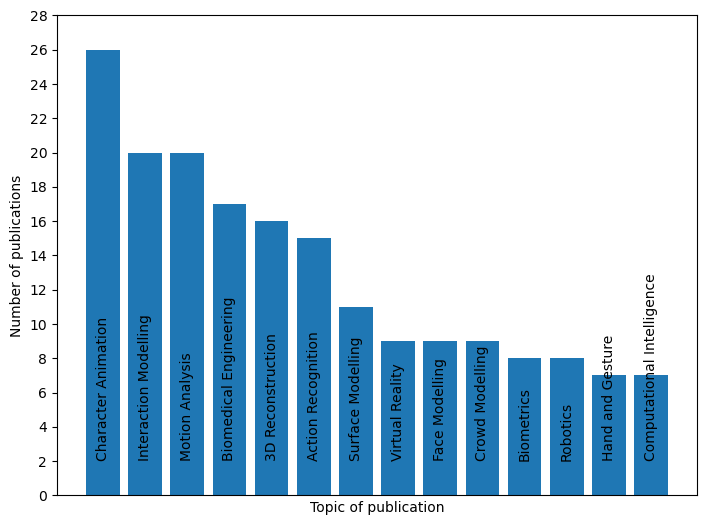

In [16]:
#Formatting data for bar chart
sorted_pubs_by_topic_tuples = sorted(pubs_by_topic.items(), key = itemgetter(1), reverse = True)
sorted_pubs_by_topic_tuples_pubs = [pub[0] for pub in sorted_pubs_by_topic_tuples]
sorted_pubs_by_topic_tuples_num = [pub[1] for pub in sorted_pubs_by_topic_tuples]

#For bar chart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(sorted_pubs_by_topic_tuples_pubs, height = sorted_pubs_by_topic_tuples_num)
ax.set_yticks(np.arange(0,30,2))
ax.set_ylabel("Number of publications")
ax.set_xlabel("Topic of publication")

plt.tick_params(
    bottom = False,
    labelbottom = False
)

bars = ax.patches
for bar, topic in zip(bars, sorted_pubs_by_topic_tuples_pubs):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 2, topic, rotation = 90, color = 'black', ha="center", va="bottom"
    )

plt.show()

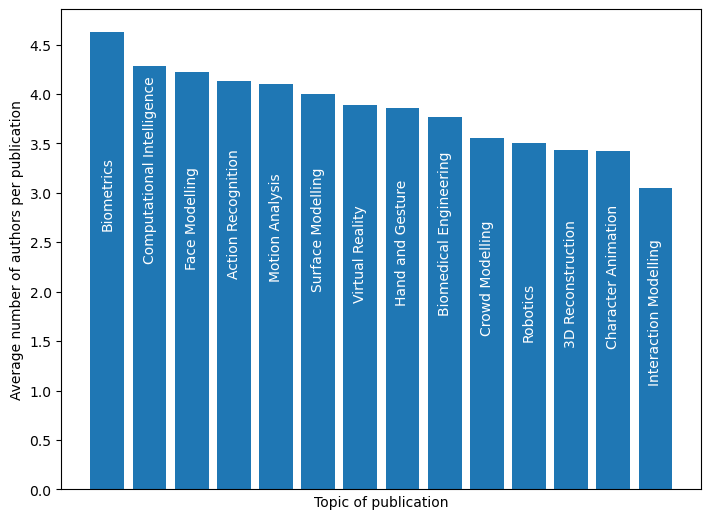

In [17]:
#Formatting data for bar chart
avg_authors_per_pub_in_topic_tuples = sorted(avg_authors_per_pub_in_topic.items(), key = itemgetter(1), reverse = True)
avg_authors_per_pub_in_topic_topics = [avg[0] for avg in avg_authors_per_pub_in_topic_tuples]
avg_authors_per_pub_in_topic_avgs = [avg[1] for avg in avg_authors_per_pub_in_topic_tuples]

#For bar chart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(avg_authors_per_pub_in_topic_topics, height = avg_authors_per_pub_in_topic_avgs)
ax.set_yticks(np.arange(0,5,0.5))
ax.set_ylabel("Average number of authors per publication")
ax.set_xlabel("Topic of publication")
plt.tick_params(
    bottom = False,
    labelbottom = False
)

bars = ax.patches
for bar, topic in zip(bars, avg_authors_per_pub_in_topic_topics):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, height-2, topic, rotation = 90, color = '#FFFFFF', ha="center", va="bottom"
    )

plt.show()


Question 3b

In [18]:
#Print all the details about the publications from the top 10 cited authors
list_of_pub_details = []
pub_cit_nos = []
pub_years = []
pub_no_LDOs = []
pub_no_topics = []
pub_no_authors = []
pub_impact_factor = []

for pub in top_10_author_publications:
    pub_details = (pub.citation_number, f"Year: {pub.year}", f"number of LDOs: {pub.number_LDOs}", 
                  f"Topics: {pub.topics}", f"Number of topics: {len(pub.topics)}", f"Authors: {pub.authors}", 
                  f" Number of authors: {len(pub.authors)}", f"Impact factor: {pub.impact_factor}")
    list_of_pub_details.append(pub_details)
    pub_cit_nos.append(int(pub.citation_number))
    pub_years.append(int(pub.year))
    pub_no_LDOs.append(int(pub.number_LDOs))
    pub_no_topics.append(len(pub.topics))
    pub_no_authors.append(len(pub.authors))
    if pub.impact_factor == None:
        pub_impact_factor.append(0)
    else:
        pub_impact_factor.append(float(pub.impact_factor))
        
    
pub_details_by_citation = sorted(list_of_pub_details, key = itemgetter(0), reverse = True)
print(*pub_details_by_citation, sep = "\n\n")


(228, 'Year: 2021', 'number of LDOs: 5', "Topics: ['Character Animation']", 'Number of topics: 1', "Authors: ['Qianhui Men', 'Edmond S. L. Ho', 'Hubert P. H. Shum', 'Howard Leung']", ' Number of authors: 4', 'Impact factor: .685')

(201, 'Year: 2008', 'number of LDOs: 8', "Topics: ['Character Animation', 'Interaction Modelling']", 'Number of topics: 2', "Authors: ['Hubert P. H. Shum', 'Taku Komura', 'Masashi Shiraishi', 'Shuntaro Yamazaki']", ' Number of authors: 4', 'Impact factor: .414')

(150, 'Year: 2013', 'number of LDOs: 5', "Topics: ['3D Reconstruction']", 'Number of topics: 1', "Authors: ['Hubert P. H. Shum', 'Edmond S. L. Ho', 'Yang Jiang', 'Shu Takagi']", ' Number of authors: 4', 'Impact factor: 1.448')

(112, 'Year: 2012', 'number of LDOs: 6', "Topics: ['Character Animation', 'Interaction Modelling']", 'Number of topics: 2', "Authors: ['Hubert P. H. Shum', 'Taku Komura', 'Shuntaro Yamazaki']", ' Number of authors: 3', 'Impact factor: .579')

(112, 'Year: 2007', 'number of LD

[[1.         0.26285531]
 [0.26285531 1.        ]]


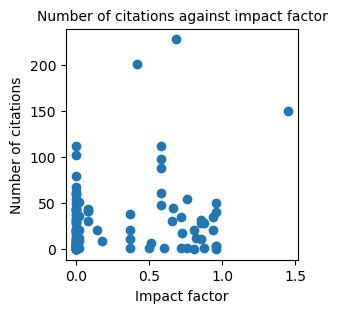

[[ 1.        -0.3260679]
 [-0.3260679  1.       ]]


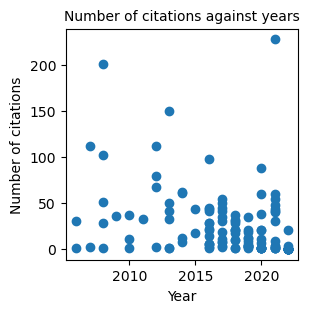

[[1.         0.46685658]
 [0.46685658 1.        ]]


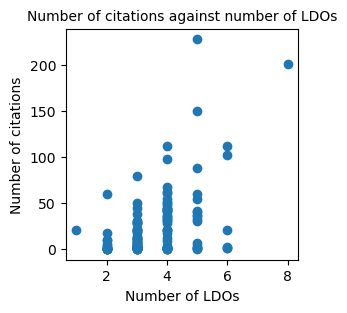

[[1.         0.00132953]
 [0.00132953 1.        ]]


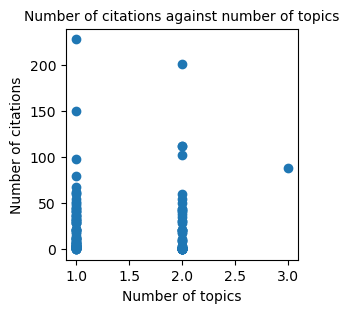

[[1.         0.03895068]
 [0.03895068 1.        ]]


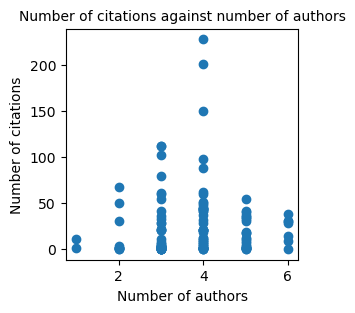

[('Character Animation', 1183), ('Interaction Modelling', 835), ('3D Reconstruction', 495), ('Motion Analysis', 420), ('Action Recognition', 404), ('Crowd Modelling', 228), ('Virtual Reality', 204), ('Biomedical Engineering', 196), ('Hand and Gesture', 146), ('Robotics', 139), ('Face Modelling', 126), ('Biometrics', 93), ('Surface Modelling', 90), ('Computational Intelligence', 88)]
[('Character Animation', 45.5), ('Interaction Modelling', 41.75), ('3D Reconstruction', 30.9375), ('Action Recognition', 26.933333333333334), ('Crowd Modelling', 25.333333333333332), ('Virtual Reality', 22.666666666666668), ('Motion Analysis', 21.0), ('Hand and Gesture', 20.857142857142858), ('Robotics', 17.375), ('Face Modelling', 14.0), ('Computational Intelligence', 12.571428571428571), ('Biometrics', 11.625), ('Biomedical Engineering', 11.529411764705882), ('Surface Modelling', 8.181818181818182)]


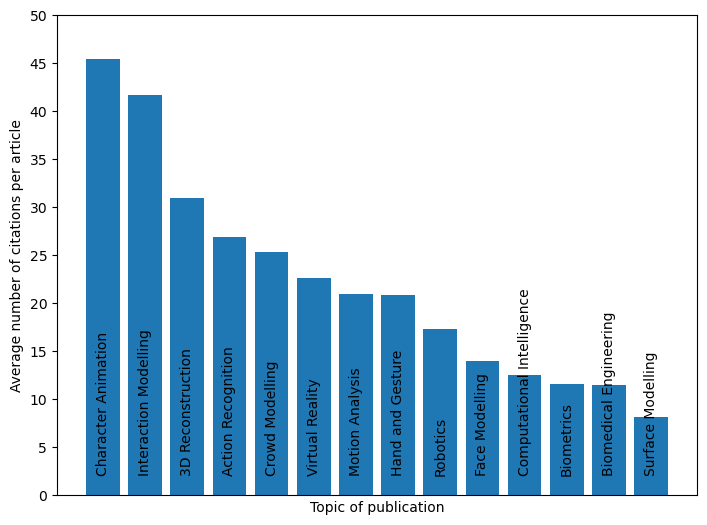

In [19]:
#correlations
print(np.corrcoef(pub_cit_nos, pub_impact_factor))

plt.figure(figsize=(3,3))
plt.scatter(pub_impact_factor, pub_cit_nos)
plt.title("Number of citations against impact factor", fontsize = 10)
plt.xlabel('Impact factor', fontsize=10)
plt.ylabel('Number of citations', fontsize=10)
plt.show()

print(np.corrcoef(pub_cit_nos, pub_years))

plt.figure(figsize=(3,3))
plt.scatter(pub_years, pub_cit_nos)
plt.title("Number of citations against years", fontsize = 10)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Number of citations', fontsize=10)
plt.show()

print(np.corrcoef(pub_cit_nos, pub_no_LDOs))
plt.figure(figsize=(3,3))
plt.scatter(pub_no_LDOs, pub_cit_nos)
plt.title("Number of citations against number of LDOs", fontsize = 10)
plt.xlabel('Number of LDOs', fontsize=10)
plt.ylabel('Number of citations', fontsize=10)
plt.show()

print(np.corrcoef(pub_cit_nos, pub_no_topics))
plt.figure(figsize=(3,3))
plt.scatter(pub_no_topics, pub_cit_nos)
plt.title("Number of citations against number of topics", fontsize = 10)
plt.xlabel('Number of topics', fontsize=10)
plt.ylabel('Number of citations', fontsize=10)
plt.show()

print(np.corrcoef(pub_cit_nos, pub_no_authors))
plt.figure(figsize=(3,3))
plt.scatter(pub_no_authors, pub_cit_nos)
plt.title("Number of citations against number of authors", fontsize = 10)
plt.xlabel('Number of authors', fontsize=10)
plt.ylabel('Number of citations', fontsize=10)
plt.show()

#changing data into the right form so it can be presented as a bar chart.
citations_by_topic_ordered = sorted(citations_by_topic.items(), key = itemgetter(1), reverse = True)
citations_by_topic_ordered_topics = [topic[0] for topic in citations_by_topic_ordered]
citations_by_topic_ordered_citations = [topic[1] for topic in citations_by_topic_ordered]
print(citations_by_topic_ordered)

avg_cits_per_pub_per_topic = dict()
for topic in pubs_by_topic:
    avg = citations_by_topic[topic] / pubs_by_topic[topic]
    avg_cits_per_pub_per_topic[topic] = avg
    
avg_cits_per_pub_per_topic_ordered = sorted(avg_cits_per_pub_per_topic.items(), key = itemgetter(1), reverse = True)
avg_cits_per_pub_per_topic_topics = [topic[0] for topic in avg_cits_per_pub_per_topic_ordered]
avg_cits_per_pub_per_topic_avgs = [topic[1] for topic in avg_cits_per_pub_per_topic_ordered]
print(avg_cits_per_pub_per_topic_ordered)
    
#For bar chart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(avg_cits_per_pub_per_topic_topics, height = avg_cits_per_pub_per_topic_avgs)
ax.set_ylabel("Average number of citations per article")
ax.set_yticks(np.arange(0,55,5))
ax.set_xlabel("Topic of publication")
plt.tick_params(
    bottom = False,
    labelbottom = False
)

bars = ax.patches
for bar, topic in zip(bars, avg_cits_per_pub_per_topic_topics):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 2, topic, rotation = 90, color = 'black', ha="center", va="bottom"
    )

plt.show()


Question 3c

In [20]:
#Define a function that returns the type of venue.
def whichVenue(pub_page_link):
    soup = createPageSoup(pub_page_link)
    endnote = soup.find_all("p", class_ = "TextSmallDefault")
    for note in endnote:
        if note.text.startswith("TY"):
            return(note.text[6:10])

In [21]:
# make a dict for whether a venue has an impact factor

does_venue_impact_factor = dict()
for pub_page in pub_page_objects:
    if pub_page.impact_factor != None:
        does_venue_impact_factor[whichVenue(pub_page.link)] = does_venue_impact_factor.get(whichVenue(pub_page.link), 0) + 1
    else:
        does_venue_impact_factor[whichVenue(pub_page.link)] = does_venue_impact_factor.get(whichVenue(pub_page.link), 0)
    print(pub_page.impact_factor, whichVenue(pub_page.link))

print(does_venue_impact_factor)
    
#Impact factors only available for JOURNAL publications, 
#though not all journal publications have an associated impact factor (only 49 do).

None CONF
.579 JOUR
None CONF
.757 JOUR
None CONF
None CONF
None CONF
None CONF
.954 JOUR
None JOUR
None CONF
None CONF
.579 JOUR
.954 JOUR
.367 JOUR
None CONF
.661 JOUR
None CONF
None CONF
None CONF
.020 JOUR
.954 JOUR
None CONF
.579 JOUR
.685 JOUR
None CONF
None CONF
None CONF
.020 JOUR
.820 JOUR
None CONF
None CONF
None CONF
None JOUR
None CHAP
.367 JOUR
None JOUR
.496 JOUR
None CONF
None CONF
None CONF
0.856 JOUR
.802 JOUR
.020 JOUR
None CONF
.020 JOUR
None CONF
None CONF
.367 JOUR
None CONF
None CONF
.020 JOUR
.579 JOUR
.954 JOUR
.513 JOUR
None CONF
.601 JOUR
None Prep
.078 JOUR
None CONF
None CONF
None CONF
None JOUR
None CONF
None CONF
.876 JOUR
None CONF
.656 JOUR
None JOUR
.936 JOUR
None CONF
.414 JOUR
.936 JOUR
None CONF
None CONF
None CONF
.178 JOUR
None CONF
None CONF
1.448 JOUR
None CONF
None CONF
.719 JOUR
.579 JOUR
None JOUR
.078 JOUR
.078 JOUR
0.856 JOUR
None CONF
None CONF
None CONF
None CONF
.020 JOUR
None JOUR
.719 JOUR
.367 JOUR
.876 JOUR
None CONF
None CONF
None JO

{'CONF': 0, 'JOUR': 49, 'CHAP': 0, 'Prep': 0, 'THES': 0, 'GENA': 0} [49, 0, 0, 0, 0, 0]


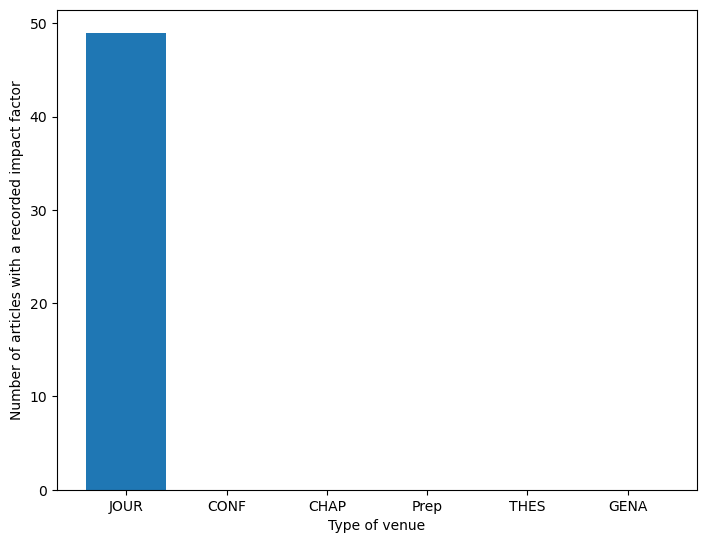

In [22]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
does_venue_impact_factor_sorted = sorted(does_venue_impact_factor.items(), key = itemgetter(1), reverse = True)
does_venue_impact_factor_venue = [venue[0] for venue in does_venue_impact_factor_sorted]
does_venue_impact_factor_number = [venue[1] for venue in does_venue_impact_factor_sorted]

print(does_venue_impact_factor, does_venue_impact_factor_number)
ax.bar(does_venue_impact_factor_venue, height = does_venue_impact_factor_number)
ax.set_ylabel("Number of articles with a recorded impact factor")
ax.set_xlabel("Type of venue")
plt.show()

Question 4

In [23]:
old_df=pd.read_csv('covid.csv', sep=',', header=0)
old_df.head()
#seems like level is the severity of disease

,id,headache,lossOfSmell,musclePain,cough,soreThroat,chestPain,fever,hoarseness,lossOfAppetite,diarrhea,fatigue,confusion,shortnessOfBreath,AbdominalPain,level
0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1
1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,0,2
2,2,1,1,0,0,1,1,0,0,1,1,0,0,0,0,3
3,3,1,1,0,1,0,1,1,1,0,1,1,0,0,0,4
4,4,1,1,1,1,1,1,1,1,1,0,1,1,0,0,5


In [24]:
#all variables except id and level are binary variables
#might be a good idea to exclude id?
df = old_df.drop("id", axis = 1)

df.info() #tells us there are 15 variables
df.describe().transpose()
#count is equal for all values which is good

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   headache           200000 non-null  int64
 1   lossOfSmell        200000 non-null  int64
 2   musclePain         200000 non-null  int64
 3   cough              200000 non-null  int64
 4   soreThroat         200000 non-null  int64
 5   chestPain          200000 non-null  int64
 6   fever              200000 non-null  int64
 7   hoarseness         200000 non-null  int64
 8   lossOfAppetite     200000 non-null  int64
 9   diarrhea           200000 non-null  int64
 10  fatigue            200000 non-null  int64
 11  confusion          200000 non-null  int64
 12  shortnessOfBreath  200000 non-null  int64
 13  AbdominalPain      200000 non-null  int64
 14  level              200000 non-null  int64
dtypes: int64(15)
memory usage: 22.9 MB


,count,mean,std,min,25%,50%,75%,max
headache,200000.0,0.714715,0.451551,0.0,0.0,1.0,1.0,1.0
lossOfSmell,200000.0,0.714290,0.451753,0.0,0.0,1.0,1.0,1.0
musclePain,200000.0,0.571470,0.494867,0.0,0.0,1.0,1.0,1.0
cough,200000.0,0.642715,0.479201,0.0,0.0,1.0,1.0,1.0
soreThroat,200000.0,0.642940,0.479134,0.0,0.0,1.0,1.0,1.0
chestPain,200000.0,0.642990,0.479119,0.0,0.0,1.0,1.0,1.0
fever,200000.0,0.571660,0.494839,0.0,0.0,1.0,1.0,1.0
hoarseness,200000.0,0.572810,0.494672,0.0,0.0,1.0,1.0,1.0
lossOfAppetite,200000.0,0.572065,0.494781,0.0,0.0,1.0,1.0,1.0
diarrhea,200000.0,0.501635,0.499999,0.0,0.0,1.0,1.0,1.0


In [25]:
#All variables except 'level' are binary, so we turn them from continuous to categorical.
headache_labels = ['1. 0', '2. 1']
lossOfSmell_labels = ['1. 0', '2. 1']
musclePain_labels = ['1. 0', '2. 1']
cough_labels = ['1. 0', '2. 1']
soreThroat_labels = ['1. 0', '2. 1']
chestPain_labels = ['1. 0', '2. 1']
fever_labels = ['1. 0', '2. 1']
hoarseness_labels = ['1. 0', '2. 1']
lossOfAppetite_labels = ['1. 0', '2. 1']
diarrhea_labels = ['1. 0', '2. 1']
fatigue_labels = ['1. 0', '2. 1']
confusion_labels = ['1. 0', '2. 1']
shortnessOfBreath_labels = ['1. 0', '2. 1']
AbdominalPain_labels = ['1. 0', '2. 1']
level_labels = ['1. 0', '2. 1', '3. 2', '4. 3', '5. 4', '6. 5', '7. 6'] 

In [26]:
#now we create a function that will make our dataframe discrete using the pd.cut() function
def discretize(df):

    discretized_df = pd.DataFrame()

    discretized_df['headache'] = pd.cut(df['headache'], bins=2, labels=headache_labels, precision=2)
    discretized_df['lossOfSmell'] = pd.cut(df['lossOfSmell'], bins=2, labels=lossOfSmell_labels, precision=2)
    discretized_df['musclePain'] = pd.cut(df['musclePain'], bins=2, labels=musclePain_labels, precision=2)
    discretized_df['cough'] = pd.cut(df['cough'], bins=2, labels=cough_labels, precision=2)
    discretized_df['soreThroat'] = pd.cut(df['soreThroat'], bins=2, labels=soreThroat_labels, precision=2)
    discretized_df['chestPain'] = pd.cut(df['chestPain'], bins=2, labels=chestPain_labels, precision=2)
    discretized_df['fever'] = pd.cut(df['fever'], bins=2, labels=fever_labels, precision=2)
    discretized_df['hoarseness'] = pd.cut(df['hoarseness'], bins=2, labels=hoarseness_labels, precision=2)
    discretized_df['lossOfAppetite'] = pd.cut(df['lossOfAppetite'], bins=2, labels=lossOfAppetite_labels, precision=2)
    discretized_df['diarrhea'] = pd.cut(df['diarrhea'], bins=2, labels=diarrhea_labels, precision=2)
    discretized_df['fatigue'] = pd.cut(df['fatigue'], bins=2, labels=fatigue_labels, precision=2)
    discretized_df['confusion'] = pd.cut(df['confusion'], bins=2, labels=confusion_labels, precision=2)
    discretized_df['shortnessOfBreath'] = pd.cut(df['shortnessOfBreath'], bins=2, labels=shortnessOfBreath_labels, precision=2)
    discretized_df['AbdominalPain'] = pd.cut(df['AbdominalPain'], bins=2, labels=AbdominalPain_labels, precision=2)
    discretized_df['level'] = pd.cut(df['level'], bins=7, labels=level_labels, precision=2)

    discretized_df = discretized_df.astype('object')

    return discretized_df

In [27]:
discretized_df = discretize(df)

In [28]:
#Split the training and test data
train_data, test_data = train_test_split(discretized_df, test_size=0.25, random_state=5)

In [29]:
treesearch = TreeSearch(data=train_data, root_node = "headache")
tree_graph = treesearch.estimate(estimator_type = "tan", class_node = "level")

Building tree:   0%|          | 0/105.0 [00:00<?, ?it/s]

In [30]:
print(tree_graph)

DAG with 15 nodes and 27 edges


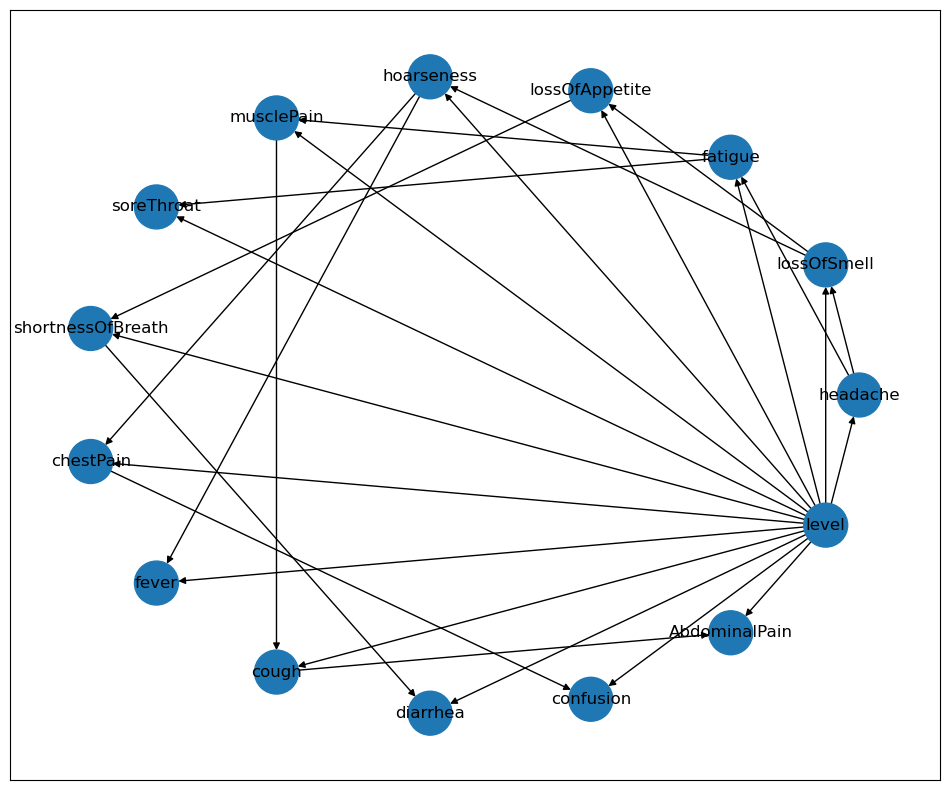

In [31]:
plt.figure(figsize=(12,10)) 
#create a DAG graph
graph = nx.DiGraph()

#add the edges and nodes 
graph.add_edges_from(tree_graph.edges)
graph.add_nodes_from(tree_graph.nodes)

#display the results in a circular layout 
position = nx.circular_layout(graph)

#draw the network
nx.draw_networkx(graph,
                pos=position,
                with_labels=True,
                node_size=[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000],
                arrowsize=10,
                alpha= 1,
                width=1) 

plt.show()

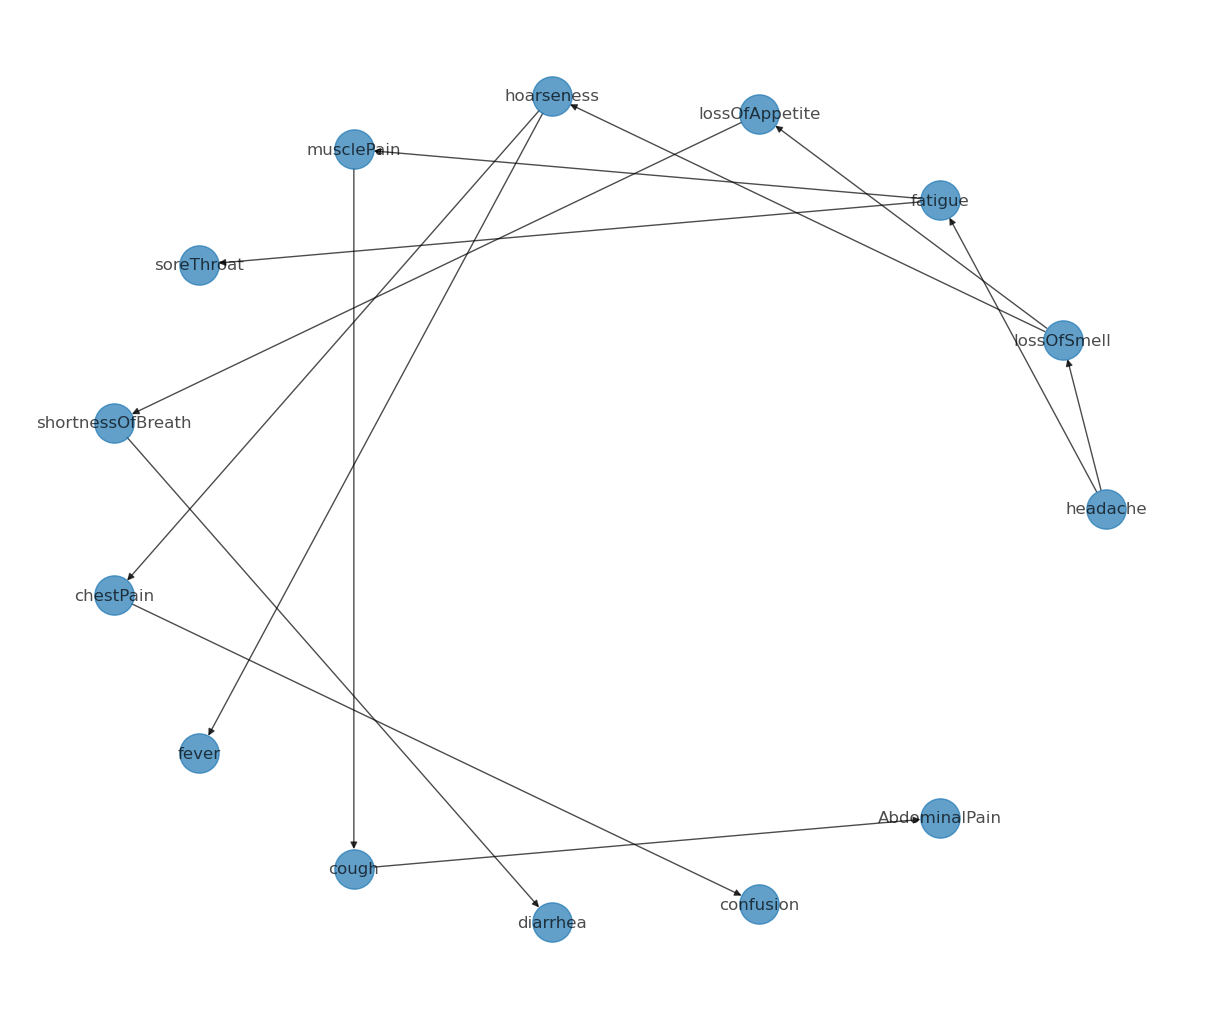

In [32]:
plt.figure(figsize=(12,10)) 

sub_graph = graph.subgraph(nodes=['headache','lossOfSmell','musclePain','cough','soreThroat','chestPain','fever','hoarseness',
                                  'lossOfAppetite','diarrhea','fatigue','confusion','shortnessOfBreath', 'AbdominalPain'])
nx.draw(sub_graph, pos=position, with_labels=True, arrowsize=10, node_size=800, alpha=0.7)
plt.show()

In [33]:
#Training the model
model = BayesianNetwork(tree_graph)
model.fit(data=train_data, 
          estimator = BayesianEstimator, 
          prior_type='BDeu')
model.get_cpds()

[<TabularCPD representing P(headache:2 | level:7) at 0x7fa4b2fd96a0>,
 <TabularCPD representing P(lossOfSmell:2 | headache:2, level:7) at 0x7fa4cf4575e0>,
 <TabularCPD representing P(fatigue:2 | headache:2, level:7) at 0x7fa4b2fd9a90>,
 <TabularCPD representing P(lossOfAppetite:2 | level:7, lossOfSmell:2) at 0x7fa4b0c03850>,
 <TabularCPD representing P(hoarseness:2 | level:7, lossOfSmell:2) at 0x7fa4b165d4f0>,
 <TabularCPD representing P(musclePain:2 | fatigue:2, level:7) at 0x7fa4b2fd9c70>,
 <TabularCPD representing P(soreThroat:2 | fatigue:2, level:7) at 0x7fa4b165d640>,
 <TabularCPD representing P(shortnessOfBreath:2 | level:7, lossOfAppetite:2) at 0x7fa4b29480a0>,
 <TabularCPD representing P(chestPain:2 | hoarseness:2, level:7) at 0x7fa4b095b4f0>,
 <TabularCPD representing P(fever:2 | hoarseness:2, level:7) at 0x7fa4b063eaf0>,
 <TabularCPD representing P(cough:2 | level:7, musclePain:2) at 0x7fa4b165d220>,
 <TabularCPD representing P(diarrhea:2 | level:7, shortnessOfBreath:2) at 0x

In [34]:
#Computing accuracy scores
symptom_accuracy = {}
for symptom in test_data:
    to_predict = test_data.copy()
    to_predict.drop(symptom, axis=1, inplace=True)
    predicted_values = model.predict(to_predict)
    accuracy = accuracy_score(test_data[symptom], predicted_values)
    print(f'{symptom} Accuracy score: {accuracy}')
    symptom_accuracy[symptom] = accuracy

  0%|          | 0/7932 [00:00<?, ?it/s]

headache Accuracy score: 0.71572


  0%|          | 0/7951 [00:00<?, ?it/s]

lossOfSmell Accuracy score: 0.71434


  0%|          | 0/7949 [00:00<?, ?it/s]

musclePain Accuracy score: 0.71494


  0%|          | 0/7927 [00:00<?, ?it/s]

cough Accuracy score: 0.71482


  0%|          | 0/7951 [00:00<?, ?it/s]

soreThroat Accuracy score: 0.7146


  0%|          | 0/7925 [00:00<?, ?it/s]

chestPain Accuracy score: 0.71594


  0%|          | 0/7917 [00:00<?, ?it/s]

fever Accuracy score: 0.71348


  0%|          | 0/7947 [00:00<?, ?it/s]

hoarseness Accuracy score: 0.71602


  0%|          | 0/7941 [00:00<?, ?it/s]

lossOfAppetite Accuracy score: 0.71248


  0%|          | 0/7941 [00:00<?, ?it/s]

diarrhea Accuracy score: 0.71514


  0%|          | 0/7951 [00:00<?, ?it/s]

fatigue Accuracy score: 0.71592


  0%|          | 0/7945 [00:00<?, ?it/s]

confusion Accuracy score: 0.71592


  0%|          | 0/7974 [00:00<?, ?it/s]

shortnessOfBreath Accuracy score: 0.71248


  0%|          | 0/7950 [00:00<?, ?it/s]

AbdominalPain Accuracy score: 0.71576


  0%|          | 0/13499 [00:00<?, ?it/s]

level Accuracy score: 0.99986


In [35]:
#Getting average accuracy
sum = 0
for acc in symptom_accuracy.values():
    sum += acc
symptom_accuracy['Average'] = sum / len(symptom_accuracy.keys())
symptom_accuracy

{'headache': 0.71572,
 'lossOfSmell': 0.71434,
 'musclePain': 0.71494,
 'cough': 0.71482,
 'soreThroat': 0.7146,
 'chestPain': 0.71594,
 'fever': 0.71348,
 'hoarseness': 0.71602,
 'lossOfAppetite': 0.71248,
 'diarrhea': 0.71514,
 'fatigue': 0.71592,
 'confusion': 0.71592,
 'shortnessOfBreath': 0.71248,
 'AbdominalPain': 0.71576,
 'level': 0.99986,
 'Average': 0.7338279999999998}

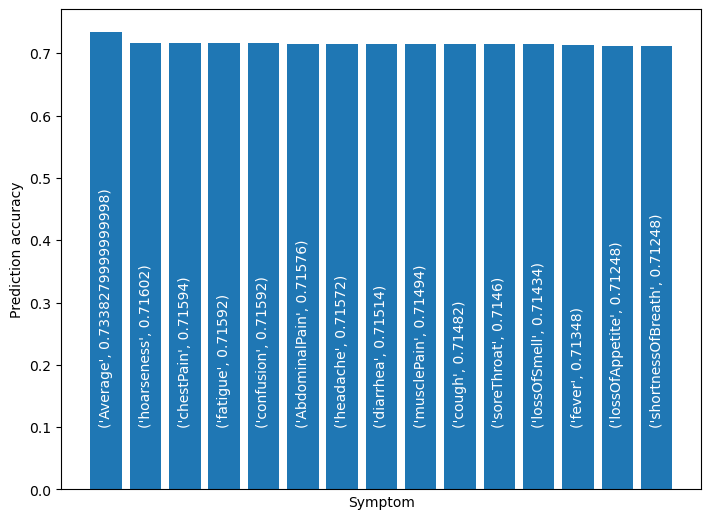

In [36]:
#Present as a bar chart.
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
symptom_accuracy_sorted = sorted(symptom_accuracy.items(), key = itemgetter(1), reverse = True)
len_symptom_accuracy_dict = len(symptom_accuracy_sorted)
symptom_accuracy_symptoms = [symptom[0] for symptom in symptom_accuracy_sorted[1:len_symptom_accuracy_dict]]
symptom_accuracy_accuracy = [symptom[1] for symptom in symptom_accuracy_sorted[1:len_symptom_accuracy_dict]]

ax.bar(symptom_accuracy_symptoms, height = symptom_accuracy_accuracy)

plt.tick_params(
    bottom = False,
    labelbottom = False
)

bars = ax.patches
for bar, topic in zip(bars, symptom_accuracy_sorted[1:len_symptom_accuracy_dict]):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2, 0.1, topic, rotation = 90, color = 'white', ha="center", va="bottom"
    )
    
ax.set_ylabel("Prediction accuracy")
ax.set_xlabel("Symptom")
plt.show()

In [37]:
#Collect various accuracy scores.
f1 = correlation_score(model=model, data=test_data, test='chi_square', significance_level=0.05, score=f1_score, return_summary=False)
accuracy = correlation_score(model=model, data=test_data, test='chi_square', significance_level=0.05, score=accuracy_score, return_summary=False)
precision = correlation_score(model=model, data=test_data, test='chi_square', significance_level=0.05, score=precision_score, return_summary=False)
recall = correlation_score(model=model, data=test_data, test='chi_square', significance_level=0.05, score=recall_score, return_summary=False)
loglikelihood = log_likelihood_score(model=model, data=test_data)
structure = structure_score(model=model, data=test_data, scoring_method='bdeu')
print(f'F1 score: {f1}')
print(f'Accuracy score: {accuracy}')
print(f'Precision score: {precision}')
print(f'Recall score: {recall}')
print(f'Log-likelihood score: {loglikelihood}')
print(f'Structure score: {structure}')

print(model.name)

/Users/Cheks/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 score: 0.0
Accuracy score: 0.9047619047619048
Precision score: 0.0
Recall score: 0.0
Log-likelihood score: -349805.4005188075
Structure score: -350265.3394476466



In [38]:
#Obtain all CPTs
for cpd in model.get_cpds():
    print(f'CPT of {cpd.variable}:')
    print(cpd * 100, '\n')

CPT of headache:
+----------------+-----+----------------------+
| level          | ... | level(7. 6)          |
+----------------+-----+----------------------+
| headache(1. 0) | ... | 0.003302073702285035 |
+----------------+-----+----------------------+
| headache(2. 1) | ... | 99.99669792629771    |
+----------------+-----+----------------------+ 

CPT of lossOfSmell:
+-------------------+-----+-----------------------+
| headache          | ... | headache(2. 1)        |
+-------------------+-----+-----------------------+
| level             | ... | level(7. 6)           |
+-------------------+-----+-----------------------+
| lossOfSmell(1. 0) | ... | 0.0016510913713964931 |
+-------------------+-----+-----------------------+
| lossOfSmell(2. 1) | ... | 99.99834890862861     |
+-------------------+-----+-----------------------+ 

CPT of fatigue:
+---------------+-------------------+-----+-----------------------+
| headache      | headache(1. 0)    | ... | headache(2. 1)        |
+--